In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

filtered_review_path = '/Users/davidcastrejon/Documents/CSC180/hw/yelp/filtered_yelp_academic_dataset_review.json'

# Load data from the reviews JSON file
print("Loading data...")
with open(filtered_review_path, 'r') as f:
    reviews_data = json.load(f)
    
# Extract text reviews and star ratings
print("Extracting text reviews and star ratings...")
texts = [review['text'] for review in reviews_data]
stars = [review['stars'] for review in reviews_data]

# TF-IDF Vectorization
print("Performing TF-IDF Vectorization...")
vectorizer = TfidfVectorizer(min_df=0.05, max_df=0.3)  
X = vectorizer.fit_transform(texts).toarray()
print("Finished TF-IDF Vectorization!")

Loading data...
Extracting text reviews and star ratings...
Performing TF-IDF Vectorization...
Finished TF-IDF Vectorization!


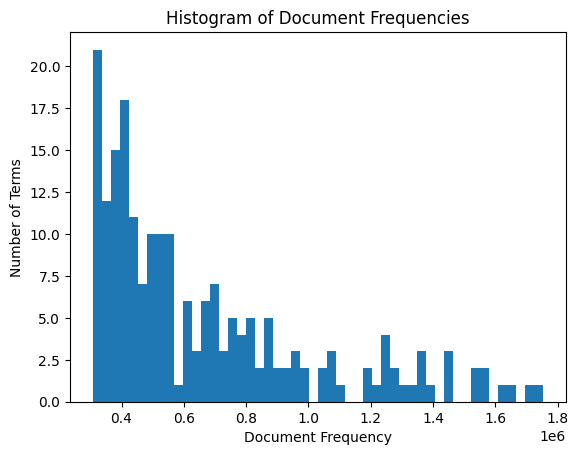

In [19]:
# Calculate document frequencies
doc_freq = np.sum(X > 0, axis=0)

# Plot histogram of document frequencies
plt.hist(doc_freq, bins=50)
plt.title('Histogram of Document Frequencies')
plt.xlabel('Document Frequency')
plt.ylabel('Number of Terms')
plt.show()

In [20]:
# Print terms with extreme document frequencies
terms = vectorizer.get_feature_names_out()
print('Nuber of features:', len(terms), '\n')
threshold = 1000
print("Terms with high document frequency:")
print([terms[i] for i in np.where(doc_freq > threshold)[0]])
threshold = 0
print("Terms with low document frequency:")
print([terms[i] for i in np.where(doc_freq < threshold)[0]])

Nuber of features: 202 

Terms with high document frequency:
['10', 'about', 'after', 'again', 'all', 'also', 'always', 'am', 'amazing', 'an', 'another', 'any', 'area', 'around', 'as', 'asked', 'atmosphere', 'away', 'awesome', 'back', 'bad', 'bar', 'because', 'been', 'before', 'being', 'best', 'better', 'big', 'bit', 'both', 'by', 'came', 'can', 'cheese', 'chicken', 'clean', 'come', 'could', 'customer', 'day', 'definitely', 'delicious', 'did', 'didn', 'different', 'dinner', 'do', 'don', 'down', 'drink', 'drinks', 'eat', 'enough', 'even', 'ever', 'every', 'everything', 'excellent', 'experience', 'favorite', 'feel', 'few', 'find', 'first', 'flavor', 'fresh', 'friendly', 'from', 'get', 'give', 'go', 'going', 'got', 'happy', 'has', 'he', 'her', 'here', 'his', 'home', 'hot', 'how', 'if', 'into', 'just', 'know', 'last', 'like', 'little', 'll', 'location', 'long', 'looking', 'lot', 'love', 'lunch', 'made', 'make', 'many', 'me', 'meal', 'menu', 'minutes', 'more', 'most', 'much', 'need', 'never

In [24]:
# Splitting the data into train and test sets
print("Splitting the data into train and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X, stars, test_size=0.2, random_state=42)

# Build the Sequential model
print("Building the Sequential model...")
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Define callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='loss', patience=3, verbose=1, restore_best_weights=True)
checkpoint_path = "model_checkpoint.keras"

model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')
# Convert NumPy arrays to TensorFlow tensors
X_train_tf = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train_tf = tf.convert_to_tensor(y_train, dtype=tf.float32)

# Train the model with early stopping and model checkpointing callbacks
print("Training the model with early stopping and model checkpointing...")
history = model.fit(X_train_tf, y_train_tf, epochs=2, batch_size=32,
                    callbacks=[early_stopping, model_checkpoint], verbose=1)

Splitting the data into train and test sets...
Building the Sequential model...
Training the model with early stopping and model checkpointing...
Epoch 1/2
152823/152857 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step - loss: 1.1899
Epoch 1: loss improved from inf to 1.06547, saving model to model_checkpoint.keras
152857/152857 ━━━━━━━━━━━━━━━━━━━━ 86s 559us/step - loss: 1.1899
Epoch 2/2
152783/152857 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step - loss: 1.0112
Epoch 2: loss improved from 1.06547 to 1.01166, saving model to model_checkpoint.keras
152857/152857 ━━━━━━━━━━━━━━━━━━━━ 83s 542us/step - loss: 1.0112
Restoring model weights from the end of the best epoch: 2.


In [ ]:
model.load_weights('model_checkpoint.keras') # load weights from best model

In [31]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Convert NumPy arrays to TensorFlow tensors
X_test_tf = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test_tf = tf.convert_to_tensor(y_test, dtype=tf.float32)

# Evaluate the model
print("Evaluating the model...")
mse = model.evaluate(X_test_tf, y_test_tf, verbose=1)
print("Mean Squared Error:", mse)

# Predict star ratings for test data
print("Predicting star ratings for test data...")
predictions = model.predict(X_test_tf)  # Obtain predictions

# Calculate regression metrics
mae = mean_absolute_error(y_test_tf, predictions)
mse = mean_squared_error(y_test_tf, predictions)
rmse = mean_squared_error(y_test_tf, predictions, squared=False)  # Compute RMSE from MSE
r2 = r2_score(y_test_tf, predictions)

# Print regression report
print("Regression Report:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2): {r2:.2f}")


Evaluating the model...
38215/38215 ━━━━━━━━━━━━━━━━━━━━ 10s 266us/step - loss: 0.9309
Mean Squared Error: 0.9307006597518921
Predicting star ratings for test data...
38215/38215 ━━━━━━━━━━━━━━━━━━━━ 11s 277us/step
Regression Report:
Mean Absolute Error (MAE): 0.73
Mean Squared Error (MSE): 0.93
Root Mean Squared Error (RMSE): 0.96
R-squared (R2): 0.55


/Users/davidcastrejon/Documents/CSC180/HW/yelp/yelp_venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
